<a href="https://colab.research.google.com/github/irene880104/datasharing/blob/master/CaLNG_demand_with_option.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)


In [ ]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [ ]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [ ]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Decision Variables

In [ ]:
# decision variables
calng_price = 7.50 # set by CaLNG
peak_intake_from_pipeline = 181

# Utility (Actual Usage)

In [ ]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [ ]:
# get usage data
usage_data = determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, 1288)

# inspect usage_data (round to 2 decimal places)
np.round(usage_data,2)

,price_index,Month,Date,Demand,pipeline_price,cost_from_pipeline_only,demand_for_lng,purchase_from_calng,pipeline_intake,pipeline_intake_price,cost_from_both,savings
0,0,December,1,94,1.00,94.00,0,0,94,1.00,94.00,0.00
1,1,December,2,304,14.39,4375.14,123,123,181,1.85,1257.85,3117.30
2,2,December,3,70,1.00,70.00,0,0,70,1.00,70.00,0.00
3,3,December,4,222,3.67,814.58,41,41,181,1.85,642.85,171.74
4,4,December,5,123,1.00,123.00,0,0,123,1.00,123.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,February,25,52,1.00,52.00,0,0,52,1.00,52.00,0.00
87,87,February,26,39,1.00,39.00,0,0,39,1.00,39.00,0.00
88,88,February,27,109,1.00,109.00,0,0,109,1.00,109.00,0.00
89,89,February,28,250,5.85,1462.83,69,69,181,1.85,852.85,609.98


In [ ]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

In [ ]:
calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, 1288)

CaLNG price: $7.50
---
Peak intake from pipeline: 181 MMcf
Total peak months intake from pipeline: 12,428 MMcf
Total intake from CaLNG: 1,288 MMcf
---
Total amount paid to pipeline: $18,463,575
Total amount paid to CaLNG: $9,660,000
Total cost for utility: $28,123,575
Savings from using CaLNG: $12,080,986
---
Total cost if average draw daily: $15,342,871


/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

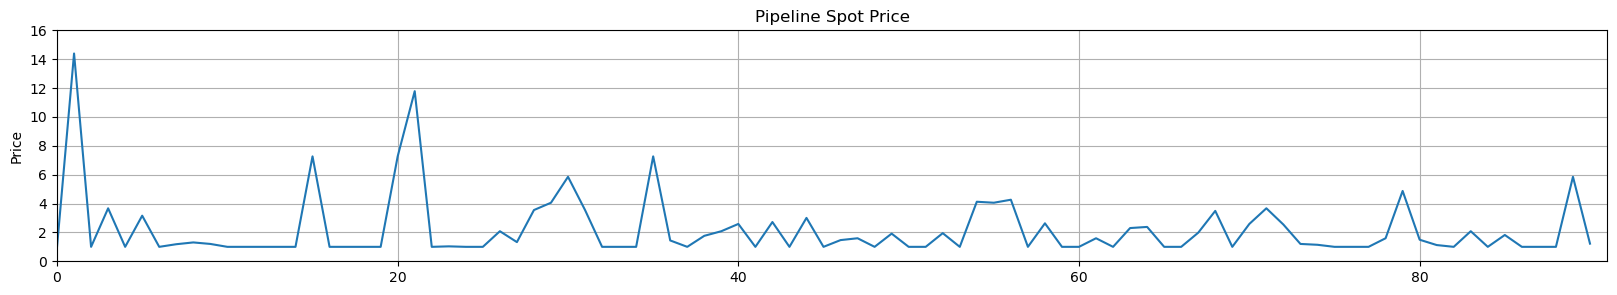

In [ ]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_price')
plt.title('Pipeline Spot Price')
plt.axis([0, 91, 0, 16])
plt.grid()
plt.xlabel("")
plt.ylabel("Price")
plt.show()

# Demand

/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

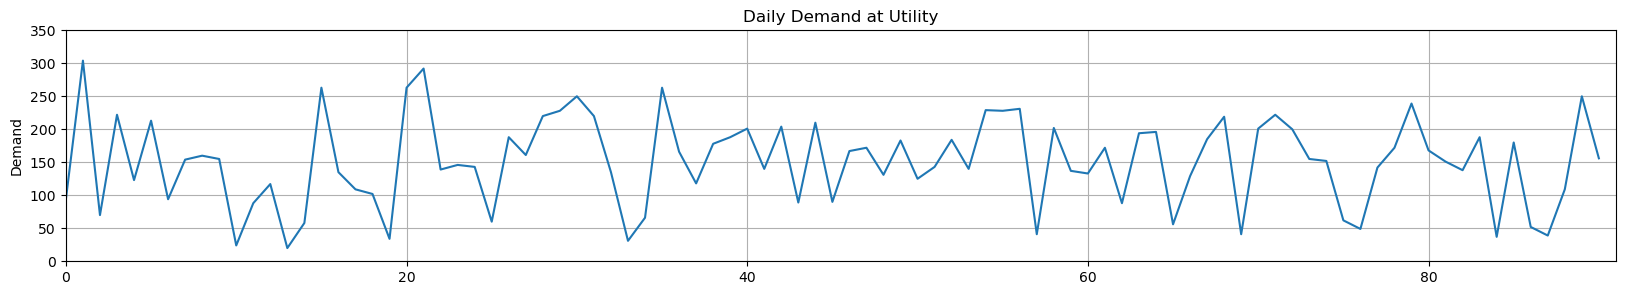

In [ ]:
sns.lineplot(data=usage_data, x='price_index', y='Demand')
plt.title('Daily Demand at Utility')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# Intake from Pipeline

/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

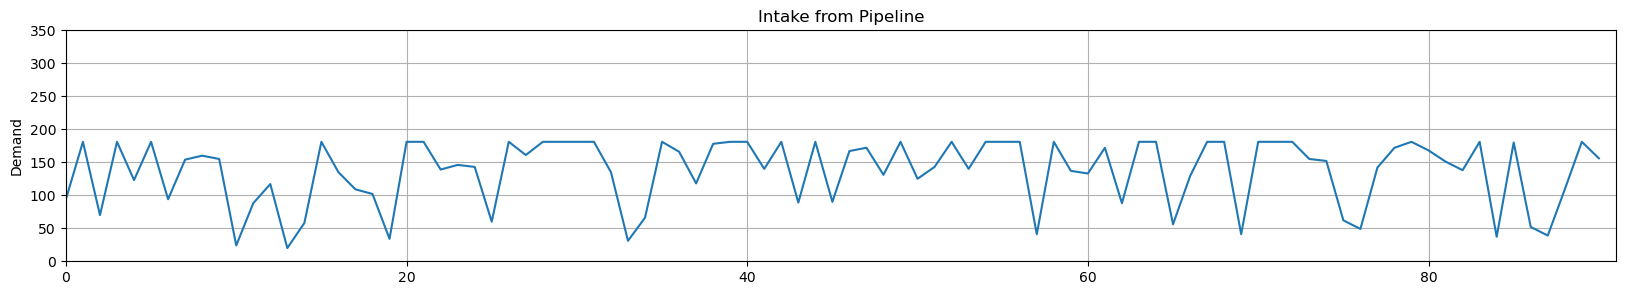

In [ ]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_intake')
plt.title('Intake from Pipeline')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# CaLNG Purchase

/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

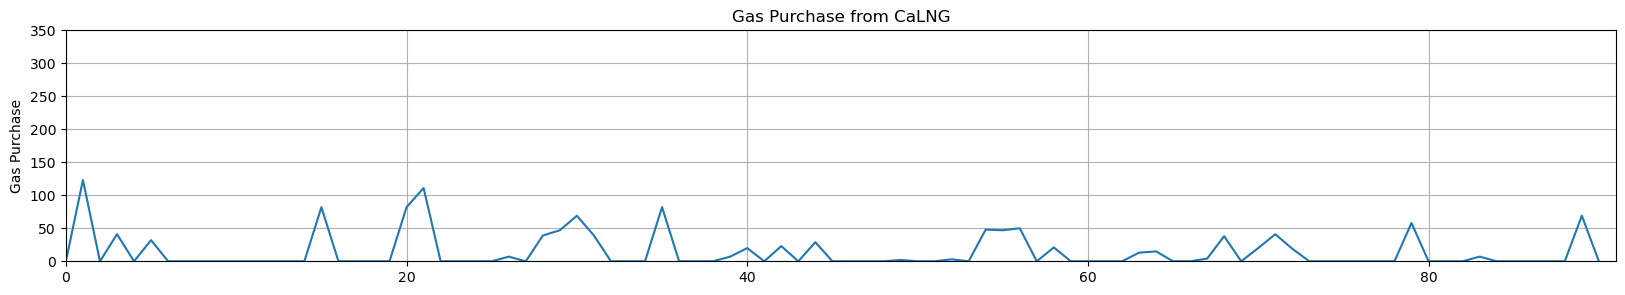

In [ ]:
sns.lineplot(data=usage_data, x='price_index', y='purchase_from_calng')
plt.title('Gas Purchase from CaLNG')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Gas Purchase")
plt.show()

# Intake vs. Spot Price

/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irene/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

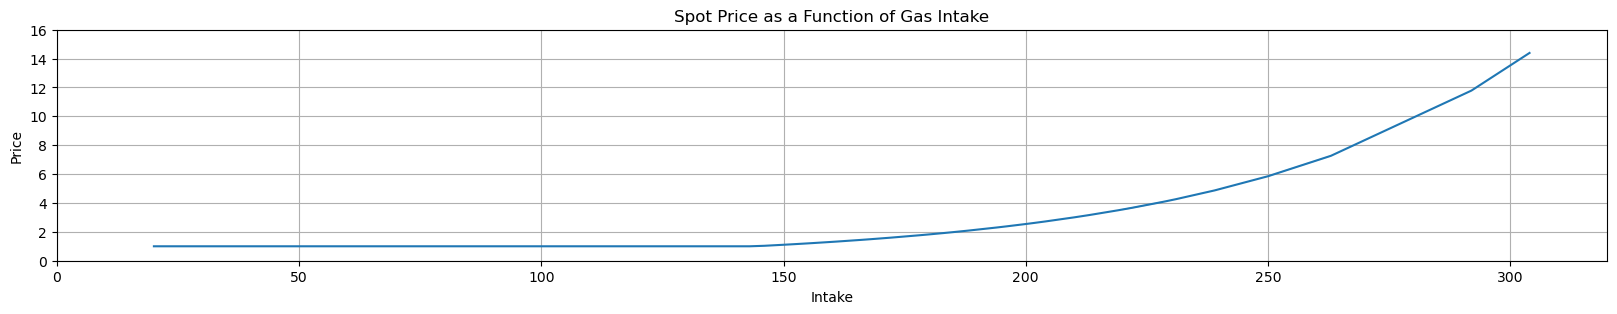

In [ ]:
sns.lineplot(data=intake_price_data, x='Intake', y='Price')
plt.title('Spot Price as a Function of Gas Intake')
plt.axis([0, 320, 0, 16])
plt.grid()
plt.show()

# Option

In [ ]:
# demand randomization parameters
mean_daily_demand = 144
std_dev_daily_demand = 59

#decision variables
total_lng = 1200
peak_intake_from_pipeline = 180

In [ ]:
# simulate demand data
sim_demand_data = demand_data.copy()

# generate sample
demand_sample = np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data))
demand_sample = np.round(np.where(demand_sample < 0, 0, demand_sample),0)

sim_demand_data['Demand'] = demand_sample
sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak_intake_from_pipeline, total_lng)

calculate_cost_statistics(sim_usage_data, calng_price, peak_intake_from_pipeline, total_lng)

CaLNG price: $7.50
---
Peak intake from pipeline: 180 MMcf
Total peak months intake from pipeline: 12,277 MMcf
Total intake from CaLNG: 665 MMcf
---
Total amount paid to pipeline: $16,600,525
Total amount paid to CaLNG: $9,000,000
Total cost for utility: $25,600,525
Savings from using CaLNG: $6,643,896
---
Total cost if average draw daily: $12,942,000


# Assignment

In [ ]:
import pandas as pd
import numpy as np
import math

# Assuming demand_data, calng_price are predefined, and 'Actual_Demand' is the correct column for demand values
num_draws = 5000
total_lng_range = range(700, 1300, 50)
peak_intake_from_pipeline_range = range(170, 200, 5)
results = []

# Corrected demand simulation
mean_demand = demand_data['Demand'].mean()
std_demand = demand_data['Demand'].std()

def simulate_demand():
    simulated_demand = np.round(np.random.normal(mean_demand, std_demand, len(demand_data)))
    return np.where(simulated_demand < 0, 0, simulated_demand)  # Ensure demand is non-negative

for total_lng in total_lng_range:
    for peak_intake in peak_intake_from_pipeline_range:
        simulation_results = []
        print(total_lng, peak_intake)

        for _ in range(num_draws):
            sim_demand_data = demand_data.copy()
            sim_demand_data['Demand'] = simulate_demand()

            sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak_intake, total_lng)
            cost_stats = calculate_cost_statistics(sim_usage_data, calng_price, peak_intake, total_lng, return_data=True)
            simulation_results.append(cost_stats)

        # Aggregate results to find average cost statistics per scenario
        avg_stats = pd.DataFrame(simulation_results).mean().to_dict()
        avg_stats.update({"total_lng": total_lng, "peak_intake_from_pipeline": peak_intake})
        results.append(avg_stats)

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)

# Find optimal scenario based on criteria (e.g., highest average savings)
optimal_scenario = results_df.loc[results_df['total_savings'].idxmax()]

print("Optimal Scenario:")
print(f"Total LNG: {optimal_scenario['total_lng']} MMcf")
print(f"Peak Intake From Pipeline: {optimal_scenario['peak_intake_from_pipeline']} MMcf")
print(f"Average Total Savings: ${optimal_scenario['total_savings']:,.2f}")

700 170
700 175
700 180
700 185
700 190
700 195
750 170
750 175
750 180
750 185
750 190
750 195
800 170
800 175
800 180
800 185
800 190
800 195
850 170
850 175
850 180
850 185
850 190
850 195
900 170
900 175
900 180
900 185
900 190
900 195
950 170
950 175
950 180
950 185
950 190
950 195
1000 170
1000 175
1000 180
1000 185
1000 190
1000 195
1050 170
1050 175
1050 180
1050 185
1050 190
1050 195
1100 170
1100 175
1100 180
1100 185
1100 190
1100 195
1150 170
1150 175
1150 180
1150 185
1150 190
1150 195
1200 170
1200 175
1200 180
1200 185
1200 190
1200 195
1250 170
1250 175
1250 180
1250 185
1250 190
1250 195
Optimal Scenario:
Total LNG: 1250.0 MMcf
Peak Intake From Pipeline: 195.0 MMcf
Average Total Savings: $15,937,087.08


In [ ]:
results_df

,peak_intake_from_pipeline,total_lng_purchase,total_pipeline_intake,total_calng_intake,total_pipeline_intake_cost,total_calng_intake_cost,total_utility_cost,total_savings,total_average_draw_daily,total_lng,average_cost
0,170,700.0,13029.4568,699.9992,3.220809e+07,5250000.0,3.745809e+07,6.840277e+06,1.569315e+07,700,2728.300844
1,175,700.0,13044.5996,699.9450,3.166155e+07,5250000.0,3.691155e+07,7.855044e+06,1.575805e+07,700,2685.542098
2,180,700.0,13060.8138,699.7496,3.065004e+07,5250000.0,3.590004e+07,8.875562e+06,1.581703e+07,700,2608.908010
3,185,700.0,13052.5600,698.2746,2.949276e+07,5250000.0,3.474276e+07,9.787152e+06,1.578072e+07,700,2526.592820
4,190,700.0,13057.0936,693.9540,2.863207e+07,5250000.0,3.388207e+07,1.092504e+07,1.578197e+07,700,2463.963067
...,...,...,...,...,...,...,...,...,...,...,...
67,175,1250.0,12522.0670,1218.5876,2.188876e+07,9375000.0,3.126376e+07,1.354558e+07,1.573831e+07,1250,2275.274564
68,180,1250.0,12560.0898,1175.9012,2.105957e+07,9375000.0,3.043457e+07,1.438711e+07,1.572279e+07,1250,2215.680874
69,185,1250.0,12635.6820,1110.8998,2.069112e+07,9375000.0,3.006612e+07,1.546564e+07,1.576008e+07,1250,2187.170588
70,190,1250.0,12719.6548,1018.6296,2.098553e+07,9375000.0,3.036053e+07,1.578261e+07,1.572079e+07,1250,2209.921347


In [ ]:
# Assuming result_df is your DataFrame
# Replace result_df with your actual DataFrame

# Specify the file path for the Excel file on your desktop
excel_file_path = '/Users/irene/Library/CloudStorage/OneDrive-EmoryUniversity/Desktop/Emory/03_Spring/result_df_output.xlsx'

# Write the DataFrame to Excel
results_df.to_excel(excel_file_path, index=False)

print(f"DataFrame successfully written to {excel_file_path}")


DataFrame successfully written to /Users/irene/Library/CloudStorage/OneDrive-EmoryUniversity/Desktop/Emory/03_Spring/result_df_output.xlsx


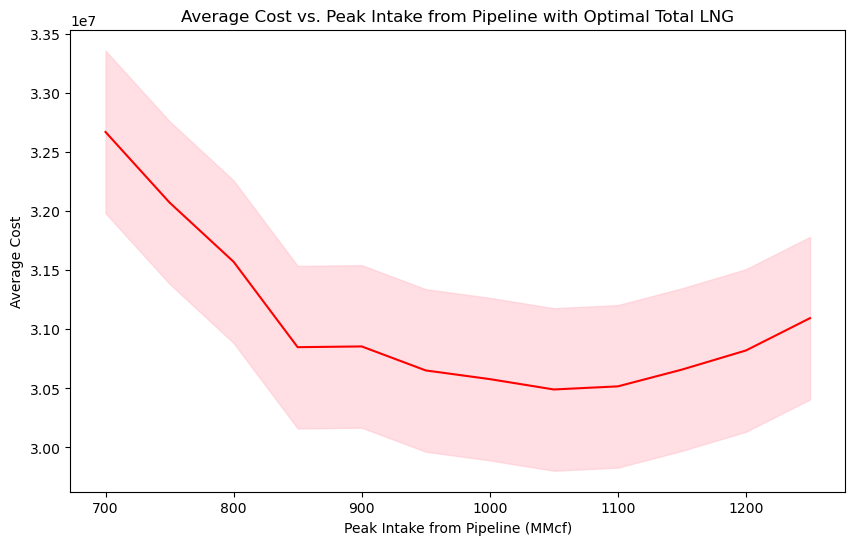

In [ ]:
## with optimal total LNG purchase
optimal_pipe_df = results_df[results_df['peak_intake_from_pipeline'] == optimal_scenario['peak_intake_from_pipeline']]
optimal_pipe_df

x_lng = optimal_pipe_df['total_lng_purchase']
y_lng = optimal_pipe_df['total_utility_cost']
std_lng = optimal_pipe_df['total_utility_cost'].std()

plt.figure(figsize=(10, 6))
plt.plot(x_lng, y_lng, label='Average Cost', color='red')
plt.fill_between(x_lng, y_lng+ std_lng, y_lng- std_lng, color='pink', alpha=0.5, label='±1 Std. Dev.')

plt.xlabel('Peak Intake from Pipeline (MMcf)')
plt.ylabel('Average Cost')
plt.title('Average Cost vs. Peak Intake from Pipeline with Optimal Total LNG')

plt.show()

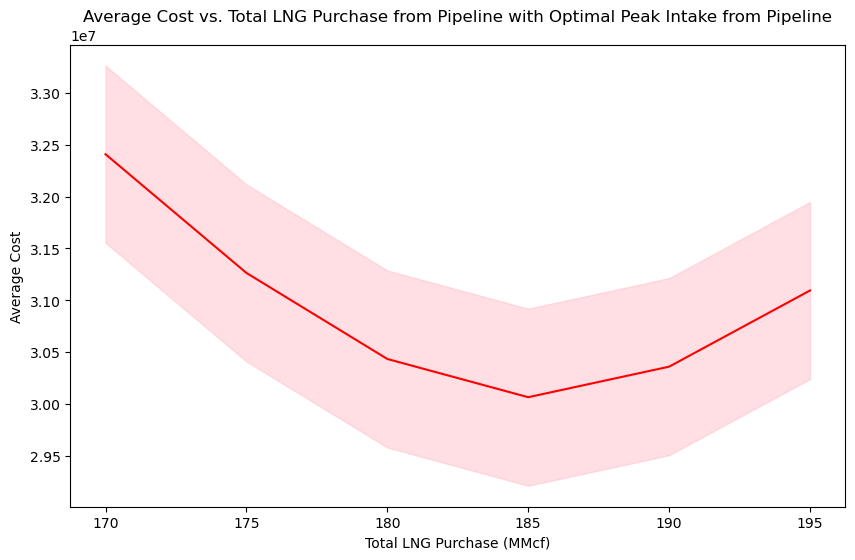

In [ ]:
## with optimal peak_intake_from_pipeline
optimal_lng_df = results_df[results_df['total_lng_purchase'] == optimal_scenario['total_lng_purchase']]


x_pipe = optimal_lng_df['peak_intake_from_pipeline']
y_pipe = optimal_lng_df['total_utility_cost']
std_pipe = optimal_lng_df['total_utility_cost'].std()

plt.figure(figsize=(10, 6))
plt.plot(x_pipe, y_pipe, label='Average Cost', color='red')
plt.fill_between(x_pipe, y_pipe+ std_pipe, y_pipe- std_pipe, color='pink', alpha=0.5, label='±1 Std. Dev.')

plt.xlabel('Total LNG Purchase (MMcf)')
plt.ylabel('Average Cost')
plt.title('Average Cost vs. Total LNG Purchase from Pipeline with Optimal Peak Intake from Pipeline')

plt.show()